In [ ]:
#| hide

import os

In [5]:
#| hide

os.chdir('../')


assert all([dir in os.listdir() for dir in ['data','configs', 'rocks_classifier']])


# Exploratory Analysis
> Let's Explore the data

In [2]:
#| hide
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import applications
from tensorflow.keras import losses
from tensorflow.keras import optimizers
import keras_cv


AUTOTUNE = tf.data.AUTOTUNE

import cv2
import os
import shutil
import numpy as np

from rocks_classifier.data.utils import *

%matplotlib inline 

# Exploring data

In [3]:
#| hide
def check_corrupted(filepath):
    # only works with jpg, does not works with png
    fobj = None
    try:
        fobj = open(filepath, "rb")
        is_JFIF = b"JFIF" in fobj.peek(10)
        
    except:
        return True
    finally:
        if fobj:
            fobj.close()
    if not is_JFIF:
        return True
    return False


In [9]:
#| hide

from typing import List

def get_dims(file: str) -> List[tuple]:
    """Return dimenstions for an RBG image.

    Parameters
    ----------
    file : str
        file path for image

    Returns
    -------
    Optional[tuple, None]
        returns a tuple of heights and width of image or None
    """
    im = cv2.imread(file)
    if im is not None:
        arr = np.array(im)
        h, w = arr.shape[0], arr.shape[1]
        return h, w
    elif im is None:
        return None

In [70]:
#|code-fold: <show|true>
df = get_df("data/2_processed")
df['dimensions'] = df['file_path'].apply(lambda x: get_dims(x))
df['image_width'] = df['dimensions'].apply(lambda x: x[0] if x is not None else None)
df['image_height'] = df['dimensions'].apply(lambda x: x[1] if x is not None else None)
df['pixels'] = df['image_width'] * df['image_height']
df['corrupt_status'] = df['file_path'].apply(lambda x: check_corrupted(x))
df

,file_name,class,file_path,file_type,dimensions,image_width,image_height,pixels,corrupt_status
0,dataset1_Limestone_147_23.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(285, 380)",285.0,380.0,108300.0,False
1,dataset2_Limestone_418_Limestone521.jpg,Limestone,data/2_processed/Limestone/dataset2_Limestone_...,.jpg,"(225, 225)",225.0,225.0,50625.0,False
2,dataset1_Limestone_315_78.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(408, 612)",408.0,612.0,249696.0,False
3,dataset1_Limestone_078_168.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(408, 612)",408.0,612.0,249696.0,False
4,dataset1_Limestone_305_69.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(408, 612)",408.0,612.0,249696.0,False
...,...,...,...,...,...,...,...,...,...
1825,dataset1_Coal_100_19.jpg,Coal,data/2_processed/Coal/dataset1_Coal_100_19.jpg,.jpg,"(252, 390)",252.0,390.0,98280.0,False
1826,dataset1_Coal_010_106.jpg,Coal,data/2_processed/Coal/dataset1_Coal_010_106.jpg,.jpg,"(252, 390)",252.0,390.0,98280.0,False
1827,dataset1_Coal_185_266.jpg,Coal,data/2_processed/Coal/dataset1_Coal_185_266.jpg,.jpg,"(183, 275)",183.0,275.0,50325.0,False
1828,dataset2_Coal_462_coal rock86.jpg,Coal,data/2_processed/Coal/dataset2_Coal_462_coal r...,.jpg,"(177, 284)",177.0,284.0,50268.0,False


## File types

In [71]:
#|code-fold: <show|true>
df['file_name'].apply(lambda x: x.split('.')[-1]).value_counts()

jpg     1797
jpeg      23
png        8
JPEG       2
Name: file_name, dtype: int64

## Corrupt file counts

In [72]:
#|code-fold: <show|true>
df['corrupt_status'] = df['file_path'].apply(lambda x: check_corrupted(x))
df.corrupt_status.value_counts()

False    1753
True       77
Name: corrupt_status, dtype: int64

Corrupted file list

In [73]:
#|code-fold: <show|true>
df[df['corrupt_status']==True]

,file_name,class,file_path,file_type,dimensions,image_width,image_height,pixels,corrupt_status
8,dataset1_Limestone_225_30.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(450, 900)",450.0,900.0,405000.0,True
10,dataset1_Limestone_265_336.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(600, 600)",600.0,600.0,360000.0,True
21,dataset1_Limestone_257_329.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(1182, 1587)",1182.0,1587.0,1875834.0,True
28,dataset1_Limestone_258_33.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(533, 800)",533.0,800.0,426400.0,True
31,dataset1_Limestone_198_276.jpg,Limestone,data/2_processed/Limestone/dataset1_Limestone_...,.jpg,"(533, 800)",533.0,800.0,426400.0,True
...,...,...,...,...,...,...,...,...,...
1758,dataset2_Coal_440_coal rock5.jpg,Coal,data/2_processed/Coal/dataset2_Coal_440_coal r...,.jpg,None,NaN,NaN,NaN,True
1803,dataset1_Coal_238_313.jpg,Coal,data/2_processed/Coal/dataset1_Coal_238_313.jpg,.jpg,"(432, 739)",432.0,739.0,319248.0,True
1804,dataset1_Coal_334_67.jpg,Coal,data/2_processed/Coal/dataset1_Coal_334_67.jpg,.jpg,"(1620, 2880)",1620.0,2880.0,4665600.0,True
1812,dataset1_Coal_044_139.jpg,Coal,data/2_processed/Coal/dataset1_Coal_044_139.jpg,.jpg,"(762, 1400)",762.0,1400.0,1066800.0,True


In [74]:
#| hide
df.describe()

,image_width,image_height,pixels
count,1828.000000,1828.000000,1.828000e+03
mean,347.844092,462.793217,2.953740e+05
std,380.091359,397.280027,1.456798e+06
min,58.000000,77.000000,4.466000e+03
25%,194.000000,259.000000,5.035800e+04
50%,252.000000,310.500000,6.552000e+04
75%,408.000000,612.000000,2.496960e+05
max,6720.000000,5472.000000,3.010560e+07


In [75]:
#| hide
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1830 entries, 0 to 1829
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       1830 non-null   object 
 1   class           1830 non-null   object 
 2   file_path       1830 non-null   object 
 3   file_type       1830 non-null   object 
 4   dimensions      1828 non-null   object 
 5   image_width     1828 non-null   float64
 6   image_height    1828 non-null   float64
 7   pixels          1828 non-null   float64
 8   corrupt_status  1830 non-null   bool   
dtypes: bool(1), float64(3), object(5)
memory usage: 116.3+ KB


In [76]:
#| hide
df['image_width'].value_counts()

408.0     220
252.0     175
194.0     132
183.0     122
225.0      91
         ... 
157.0       1
248.0       1
367.0       1
1230.0      1
762.0       1
Name: image_width, Length: 331, dtype: int64

<AxesSubplot: ylabel='image_width'>

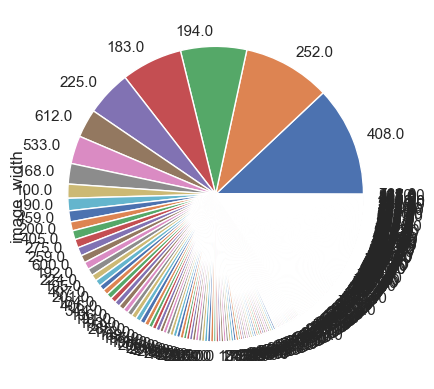

In [77]:
#| hide
df['image_width'].value_counts().plot(kind='pie')

In [78]:
#| hide
width_vc_bin = df.image_width.value_counts(bins = [i for i in range(1, 500, 20)])
width_vc_bin.values

array([440, 292, 223, 132, 129,  90,  38,  33,  28,  25,  23,  21,  19,
        16,  11,   9,   7,   6,   6,   1,   1,   0,   0,   0])

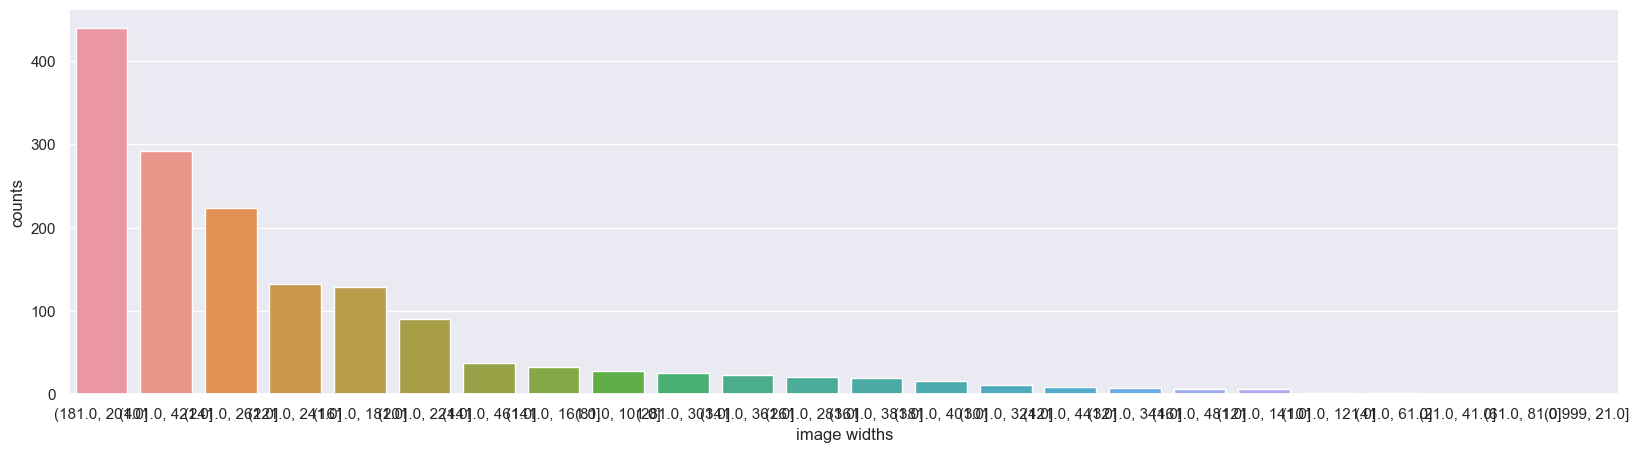

In [79]:
#| hide
import seaborn as sns
# setting the dimensions of the plot
fig, ax = plt.subplots(figsize=(20, 5))

sns.barplot(x=width_vc_bin.index, y=width_vc_bin.values)
plt.xlabel('image widths')
plt.ylabel('counts')
plt.show()

In [80]:
#| hide
# sorted(list(df['image_width'].value_counts().index))
# sorted(list(df['image_height'].value_counts().index))

In [81]:
#| hide
df['image_height'].value_counts()

612.0    398
259.0    125
275.0    111
800.0     92
225.0     91
        ... 
182.0      1
770.0      1
325.0      1
212.0      1
343.0      1
Name: image_height, Length: 296, dtype: int64

In [82]:
#| hide
min(df['class'].value_counts())

95

### Class Counts

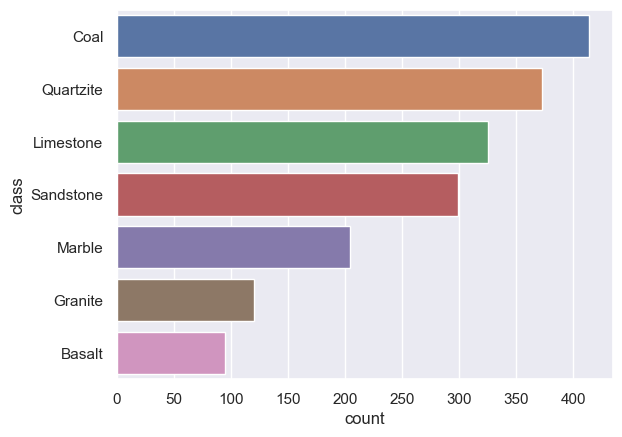

In [83]:
#|code-fold: <show|true>
import seaborn as sns
import pandas as pd

class_names = df['class'].value_counts().keys()
counts = df['class'].value_counts().values

count_df = pd.DataFrame(list(zip(class_names, counts)), columns=['class', 'count'])

sns.set_theme(style="darkgrid")
ax = sns.barplot(y='class', x='count', data=count_df)

## Image size analysis

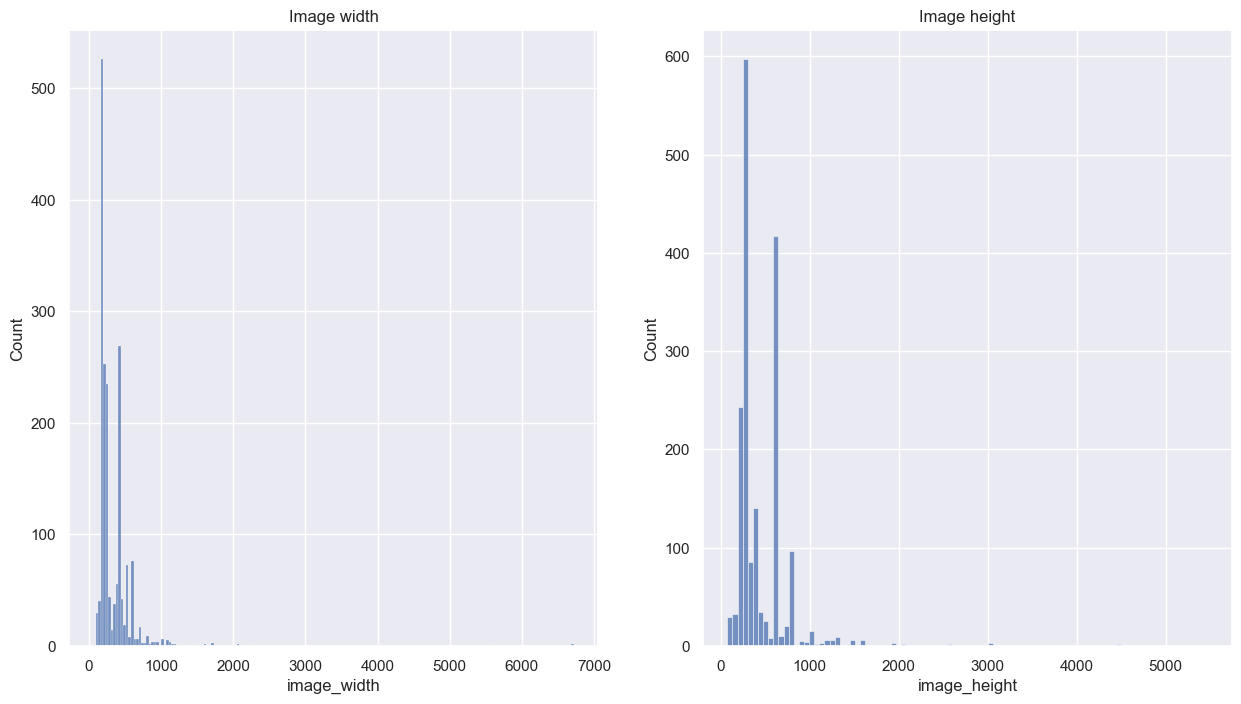

In [84]:
#|code-fold: <show|true>

width_list = df.image_width
height_list = df.image_height
average_width = sum(width_list)/len(width_list)
average_height = sum(height_list)/len(height_list)

# print('average width: {} and height: {}'.format(average_width, average_height))

fig, ax =plt.subplots(1,2, figsize=(15, 8))

sns.histplot(width_list, ax=ax[0])
ax[0].set_title('Image width');
sns.histplot(height_list, ax=ax[1])
ax[1].set_title('Image height');

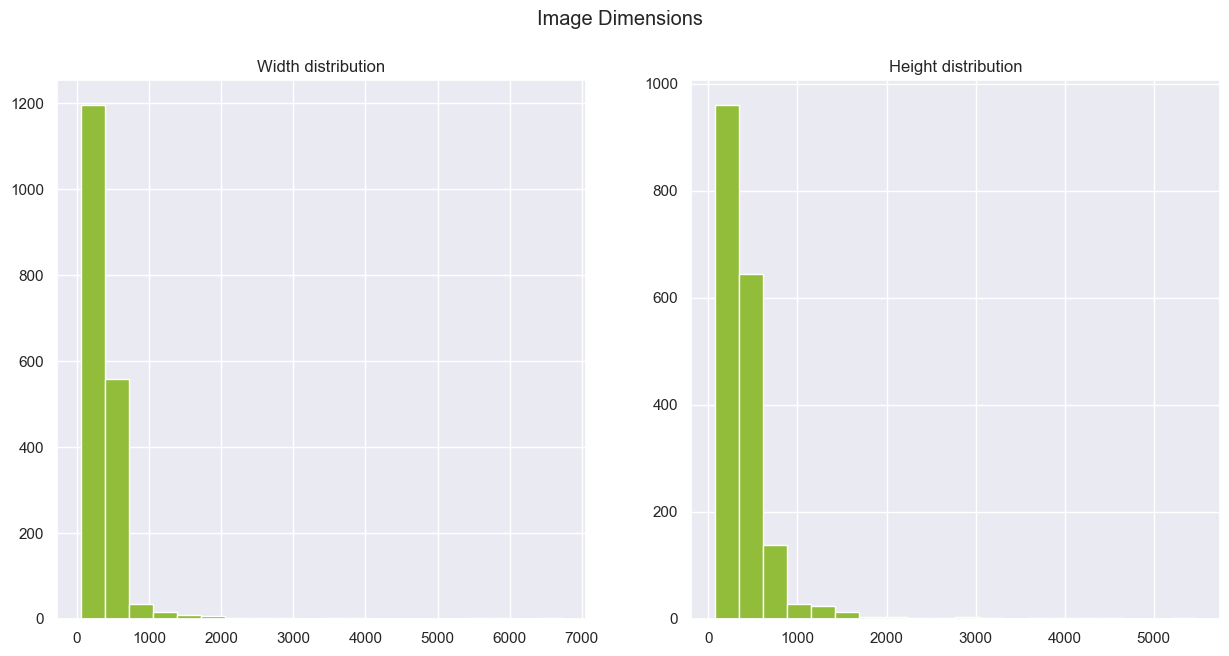

In [85]:
#|code-fold: <show|true>
# plot histograms to show the distribution of width and height values
fig, axs = plt.subplots(1,2, figsize=(15,7))
axs[0].hist(df.image_width.values, bins=20, color = '#91bd3a')
axs[0].set_title('Width distribution')
# axs[0].set_xlim(1000, 3000)

axs[1].hist(df.image_height.values, bins=20, color = '#91bd3a')
axs[1].set_title('Height distribution')
# axs[1].set_xlim(1000, 3000)

plt.suptitle('Image Dimensions')
plt.show()

## Sample counts

In [86]:
#| hide

import omegaconf
path = 'configs/config.yaml'
cfg = omegaconf.OmegaConf.load(path)

In [87]:
#|echo: false
print(f"Sampling type:- {cfg.sampling}.")

Sampling type:- None.


### Training set counts

In [88]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/train")['class'].value_counts()

Coal         289
Quartzite    261
Limestone    228
Sandstone    209
Marble       142
Granite       84
Basalt        66
Name: class, dtype: int64

### Validation set counts

In [89]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/val")['class'].value_counts()

Coal         62
Quartzite    55
Limestone    48
Sandstone    44
Marble       30
Granite      18
Basalt       14
Name: class, dtype: int64

### Test set counts

In [90]:
#|code-fold: <show|true>
get_df("data/3_tfds_dataset/test")['class'].value_counts()

Coal         63
Quartzite    57
Limestone    50
Sandstone    46
Marble       32
Granite      19
Basalt       15
Name: class, dtype: int64

# Data Augmentation

In [91]:
#| hide

# https://www.tensorflow.org/datasets/api_docs/python/tfds/folder_dataset/ImageFolder
builder = tfds.ImageFolder('data/3_tfds_dataset')
print(builder.info)  # num examples, labels... are automatically calculated
data = builder.as_dataset(split=None, as_supervised=True)

num_classes = builder.info.features['label'].num_classes

tfds.core.DatasetInfo(
    name='image_folder',
    full_name='image_folder/1.0.0',
    description="""
    Generic image classification dataset.
    """,
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    data_path='/Users/uday/tensorflow_datasets/image_folder/1.0.0',
    file_format=tfrecord,
    download_size=Unknown size,
    dataset_size=Unknown size,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=7),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=282, num_shards=1>,
        'train': <SplitInfo num_examples=1279, num_shards=1>,
        'val': <SplitInfo num_examples=271, num_shards=1>,
    },
    citation="""""",
)


## Sample Images

In [92]:
#|code-fold: <show|true>
ds = builder.as_dataset(split='train', shuffle_files=True)
# tfds.show_examples(ds, builder.info)

In [93]:
#| hide
# # https://stackoverflow.com/a/37343690/9292995
# # https://keras.io/guides/keras_cv/cut_mix_mix_up_and_rand_augment/

IMAGE_SIZE = (224, 224)


def to_dict(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, 7)
    return {"images": image, "labels": label}


def prepare_dataset(dataset, split):
    if split == "train":
        return (
            dataset.shuffle(10 * 32)
            .map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(32)
        )
    elif split == "val" or split == "test":
        return (
            dataset.map(to_dict, num_parallel_calls=AUTOTUNE)
            .batch(32)
        )


def load_dataset(split="train"):
    dataset = data[split]
    return prepare_dataset(dataset, split)


In [94]:
#| hide
def visualize_dataset(dataset, title):
    plt.figure(figsize=(12, 12)).suptitle(title, fontsize=18)
    for i, samples in enumerate(iter(dataset.take(9))):
        images = samples["images"]
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[0].numpy().astype("uint8"))
        plt.axis("off")
    plt.show()

### Samples before Augmentation

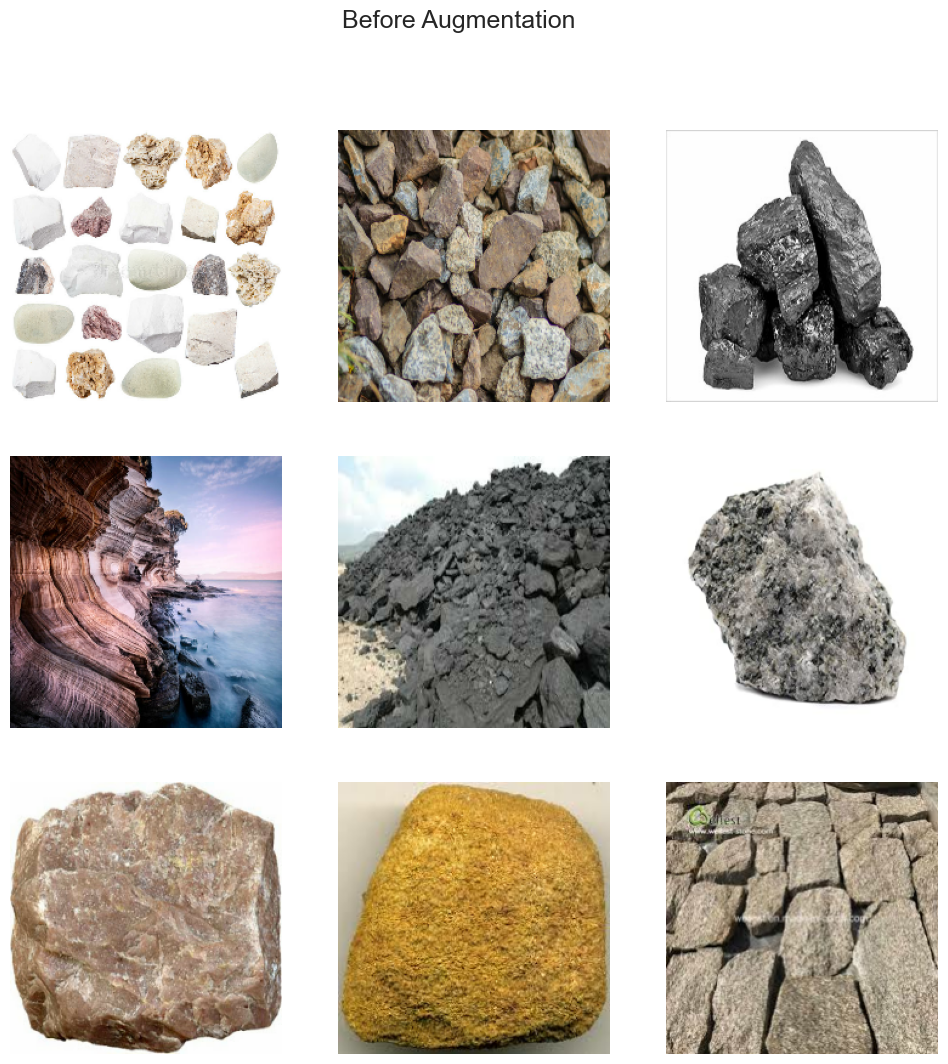

In [97]:
#|code-fold: <show|true>
train_dataset = load_dataset('val')
visualize_dataset(train_dataset, title="Before Augmentation");

### Samples after RandAugment

In [ ]:
#| hide
def apply_rand_augment(inputs):
    inputs["images"] = rand_augment(inputs["images"])
    return inputs

rand_augment = keras_cv.layers.RandAugment(
    value_range=(0, 255),
    augmentations_per_image=3,
    magnitude=0.3,
    magnitude_stddev=0.2,
    rate=0.5,
)

cut_mix = keras_cv.layers.CutMix()
mix_up = keras_cv.layers.MixUp()


def cut_mix_and_mix_up(samples):
    samples = cut_mix(samples, training=True)
    samples = mix_up(samples, training=True)
    return samples

def preprocess_for_model(inputs):
    images, labels = inputs["images"], inputs["labels"]
    images = tf.cast(images, tf.float32)
    return images, labels

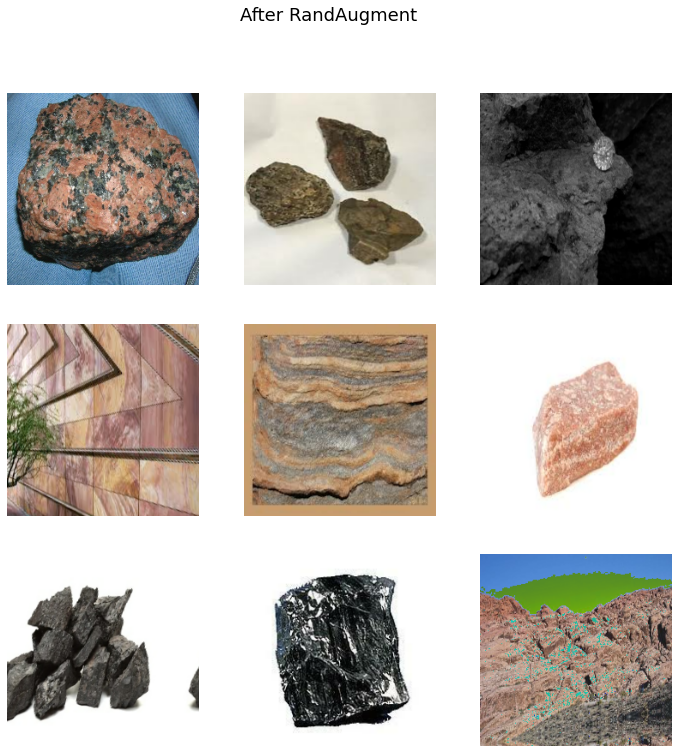

In [ ]:
#|code-fold: <show|true>
train_dataset = load_dataset().map(apply_rand_augment, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After RandAugment")

### Samples after cutmix and mixup augmentation

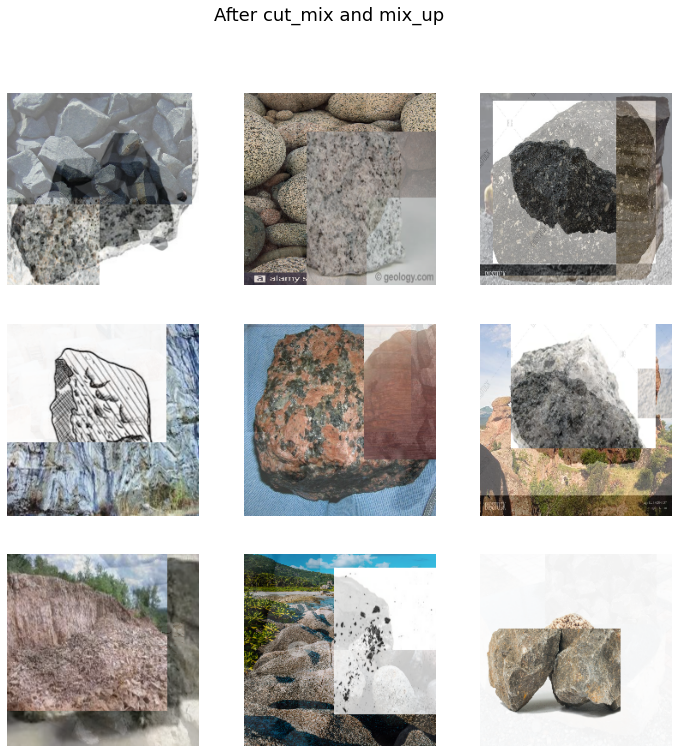

In [ ]:
#|code-fold: <show|true>
train_dataset = load_dataset().map(cut_mix_and_mix_up, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, title="After cut_mix and mix_up")